# <h1><center>TP3 - Visión por computadora - CEIA</center></h1>

In [57]:
# Importaciones
%matplotlib inline

import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
from typing import List, Tuple

<center>

<img src="./resources/portada.jpeg" width="600" alt="Figura 1: A computer vision expert, doing template matching of a dragon, in a scene of dragons fighting with a Game of Thrones setting - Generada con Microsoft Image Creator">

<small><em>Figura 1: A computer vision expert, doing template matching of a dragon, in a scene of dragons fighting with a Game of Thrones setting - Generada con Microsoft Image Creator</em></small>

</center>

<center>
<p>✨Datos del proyecto:✨<p>

| Subtitulo       | TP3 - Visión por computadora - FIUBA                                                                                                   |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Template matching                                                                                                                      |
| **Integrantes** | Bruno Masoller (brunomaso1@gmail.com)                                                                                                |

</center>

## Consinga

![Consinga](.\resources\Consigna.PNG)


## Parte 1

> Obtener una detección del logo en cada imagen sin falsos positivos

<em>
Para resolver este problema, se plantea utilizar el algoritmo de template matching, pero previamente haber aplicado un algoritmo de detección de bordes. O sea, el algoritmo es el siguiente:

1. Transformar el template matching a una imagen de bordes utilizando un algoritmo acorde (por ejemplo, Canny).
2. Transformar la imagen objetivo utilizando el mismo algoritmo.
3. Realizar el template matching.
</em>

*Exploración de las imágenes:*

*Primeramente exploramos las imágenes para investigar posibles problemas.*

🔮 <em><font color='violet'><strong>Función auxiliar:</strong> Cargar imágenes de un directorio.</font></em>

In [58]:
def load_imgs(folder):
    imgs_rgb = []
    for file_name in os.listdir(folder):
        file_route = os.path.join(folder, file_name)
        if os.path.isfile(file_route) and file_route.endswith(('.png', '.jpg', '.jpeg')):
            img_bgr = cv.imread(file_route)
            img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
            imgs_rgb.append(img_rgb)
    return imgs_rgb

🔮 <em><font color='violet'><strong>Función auxiliar:</strong> Se muestra las imágenes de una lista en una grilla.</font></em>

In [59]:
def show_imgs(imgs_rgb, title=None, col_count=3, figsize=(12, 4)):
    img_count = len(imgs_rgb)

    # Calculo la cantidad de filas según las columnas deseadas
    rows = (img_count // col_count) + \
        (1 if img_count % col_count != 0 else 0)

    fig, axes = plt.subplots(rows, col_count, figsize=(
        figsize[0], figsize[1] * rows))
    fig.suptitle(title)

    # Eliminar ejes de subplots que no se usan
    if rows * col_count == img_count:
        for i in range(rows * col_count):
            row = i // col_count
            col = i % col_count
            if i < img_count:
                axes[row, col].imshow(imgs_rgb[i])
                axes[row, col].axis('off')
            else:
                axes[row, col].axis('off')
    else:
        for i in range((rows - 1) * col_count):
            row = i // col_count
            col = i % col_count
            if i < img_count:
                axes[row, col].imshow(imgs_rgb[i])
                axes[row, col].axis('off')
            else:
                axes[row, col].axis('off')

        cols_used = img_count % col_count
        cols_empty = col_count - cols_used
        col_center = cols_empty // 2

        for col in range(col_count):
            if col < col_center or col >= col_center + cols_used:
                axes[rows - 1, col].axis('off')
            else:
                img_index = (rows - 1) * col_count + \
                    (col - col_center)
                axes[rows - 1, col].imshow(imgs_rgb[img_index])
                axes[rows - 1, col].axis('off')

    plt.tight_layout()
    plt.show()

*Mostramos todas las imágenes a procesar:*

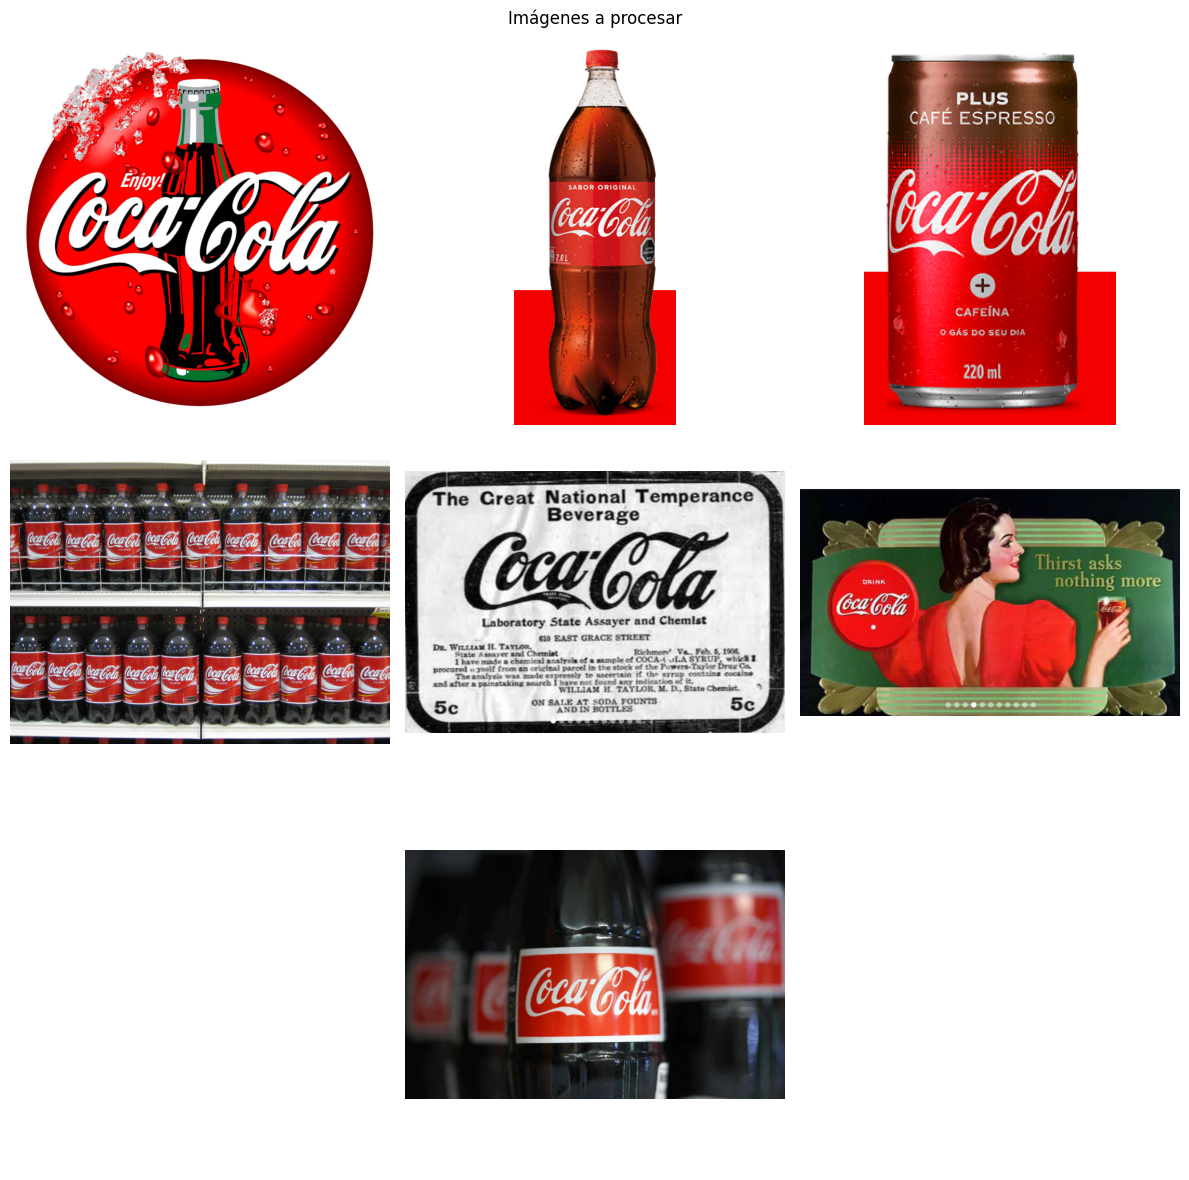

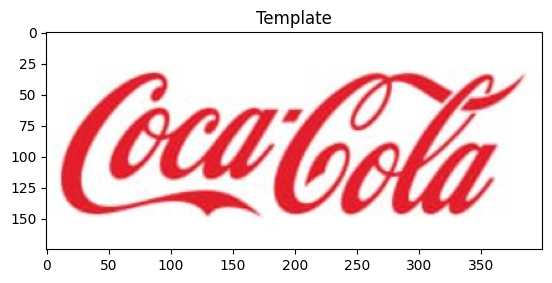

In [60]:
imgs_rgb = load_imgs('./resources/images/')
template_rgb = cv.cvtColor(
    cv.imread('./resources/template/pattern.png'), cv.COLOR_BGR2RGB)
show_imgs(imgs_rgb, title='Imágenes a procesar')

plt.figure()
plt.title('Template')
plt.imshow(template_rgb)
plt.show()

*Inicialmente podemos ver que difieren los tamaños entre el template y las imágenes, por lo que al algoritmo se propone agregarle variaciones de tamaño de lás imágenes y quedarse con la brinda mejor resultado de todas las comparaciones de tamaño.*

*Como análisis explotarorio, chequeamos que las imágenes no sean más chicas que el template:*

In [61]:
print(f'Tamaño del template: {template_rgb.shape}')
for img in imgs_rgb:
    print(f'Tamaño de imagen: {img.shape}')

Tamaño del template: (175, 400, 3)
Tamaño de imagen: (1389, 1389, 3)
Tamaño de imagen: (500, 207, 3)
Tamaño de imagen: (363, 233, 3)
Tamaño de imagen: (598, 799, 3)
Tamaño de imagen: (493, 715, 3)
Tamaño de imagen: (429, 715, 3)
Tamaño de imagen: (450, 687, 3)


*Efectivamente, tenemos imágenes más chicas que el template. Esto genera un error en el método, por lo que para subsanar este problema, reducimos el tamaño del template:*

In [62]:
template_rgb = cv.resize(template_rgb, None, fx=0.5, fy=0.5)

*Primeramente, utilizamos una función que compute todos los tamaños de las imágenes y le aplique Canny:*

In [63]:
def compute_all_img_sizes(imagen_rgb: np.ndarray, canny_thresshold: Tuple = (50, 200), linspace: Tuple = (0.05, 1.0, 50)) -> List:
    """
    Calcula los bordes de la imagen a diferentes escalas utilizando el algoritmo Canny.

    Esta función toma una imagen RGB, la convierte a escala de grises, y luego crea una lista
    de imágenes de bordes a diferentes escalas. Cada imagen de bordes se calcula utilizando
    el detector de bordes Canny.

    Args:
        imagen_rgb (np.ndarray): Imagen de entrada en formato RGB.
        canny_thresshold (Tuple[int, int], opcional): Umbrales bajo y alto para el detector Canny.
            Por defecto es (50, 200).
        linspace (Tuple[float, float, int], opcional): Parámetros para np.linspace que definen
            las escalas a utilizar. Formato: (inicio, fin, número de pasos).
            Por defecto es (0.05, 1.0, 50).

    Returns:
        List[Tuple[np.ndarray, float]]: Una lista de tuplas, donde cada tupla contiene:
            - np.ndarray: Imagen de bordes calculada con Canny.
            - float: Factor de escala utilizado para esa imagen.

    Note:
        Las imágenes se procesan de mayor a menor escala (orden inverso).
    """
    
    canny_th_low, canny_th_high = canny_thresshold
    linspace_low, linspace_high, linspace_step = linspace

    img_gray = cv.cvtColor(imagen_rgb, cv.COLOR_RGB2GRAY)

    img_edges_list = []
    for scale in np.linspace(linspace_low, linspace_high, linspace_step)[::-1]:
        img_edges_resized = cv.resize(img_gray, None, fx=scale, fy=scale)
        img_edges = cv.Canny(img_edges_resized, canny_th_low,
                             canny_th_high, L2gradient=True)
        img_edges_list.append((img_edges, scale))

    return img_edges_list

*Realizamos la función que detecta solamente una imagen mediante el siguiente algoritmo:*

In [64]:
def detect_one_object(img_rgb: np.ndarray, template_rgb: np.ndarray, linspace: Tuple = (0.05, 2, 100), canny_thresshold: Tuple = (50, 200), method=cv.TM_CCORR_NORMED, debug=True, show_best_result=True) -> np.ndarray:
    # Primeramente calculo los bordes del template
    canny_low, canny_high = canny_thresshold
    template_edge = cv.Canny(cv.cvtColor(template_rgb, cv.COLOR_BGR2GRAY), canny_low, canny_high, L2gradient=True)
    
    # Calculo todos los tamaños de las imágenes
    img_edges_list = compute_all_img_sizes(img_rgb, canny_thresshold, linspace)
    
    h, w = template_edge.shape
    best_result = None
    
    if debug: print(f'Cantidad de imagenes a procesar: {len(img_edges_list)}')
    
    # Itero sobre las imágenes y le paso el template.
    for i, (img_edges, scale) in enumerate(img_edges_list):
        img_h, img_w = img_edges.shape
        
        # Si las imagenes que vienen, son menor que el template, no tiene sentido.
        if img_h < h or img_w < w:
            if debug: print(f'img_h, img_w : {(img_h, img_w)} | h, w: {(h, w)}')
            break
        
        result = cv.matchTemplate(img_edges, template_edge, method)
        (_, max_val, _, max_loc) = cv.minMaxLoc(result)

        best_result = (max_val, max_loc, i) if (best_result is None) or (best_result[0] < max_val) else best_result

        if debug: print(f'img_edges: {i} | img_edges: {img_edges.shape} | img_edge.scale: {scale:.2f} | resultado_actual: {(max_val, max_loc, i)} | mejor_resultado: {best_result}')
    
    max_val, max_loc, i = best_result
    best_scale = img_edges_list[i][1]

    # Tengo que dividir por la escala
    top_left = (int(max_loc[0]/best_scale), int((max_loc[1]/best_scale)))
    bottom_right = (int((max_loc[0] + w) /best_scale), int((max_loc[1] + h) / best_scale))
    
    cv.rectangle(img_rgb, top_left, bottom_right, (0, 150, 0), 4)
    cv.putText(img_rgb, f'V={max_val:.2f}', (top_left[0] - 2, top_left[1] - 5), cv.FONT_HERSHEY_SIMPLEX, 1 / best_scale, (0, 150, 0),  int(2 / best_scale))
    
    if debug or show_best_result: 
        best_image_edge = img_edges_list[i][0]
        best_scale = img_edges_list[i][1]
        print(f'Mejor resultado: {best_result} | Escala: {best_scale:.2f} | best_image_edge: {best_image_edge.shape}')
        
    return img_rgb

*Aplicamos la función a todas las imágenes:*

Mejor resultado: (0.2273535132408142, (13, 70), 95) | Escala: 0.17 | best_image_edge: (235, 235)
Mejor resultado: (0.48339951038360596, (32, 226), 62) | Escala: 1.15 | best_image_edge: (576, 239)
Mejor resultado: (0.23733019828796387, (4, 96), 71) | Escala: 0.88 | best_image_edge: (321, 206)
Mejor resultado: (0.29896241426467896, (294, 871), 32) | Escala: 2.05 | best_image_edge: (1224, 1635)
Mejor resultado: (0.2790234088897705, (38, 25), 88) | Escala: 0.38 | best_image_edge: (186, 270)
Mejor resultado: (0.36124885082244873, (76, 231), 58) | Escala: 1.27 | best_image_edge: (546, 909)
Mejor resultado: (0.27879267930984497, (132, 128), 78) | Escala: 0.68 | best_image_edge: (304, 464)


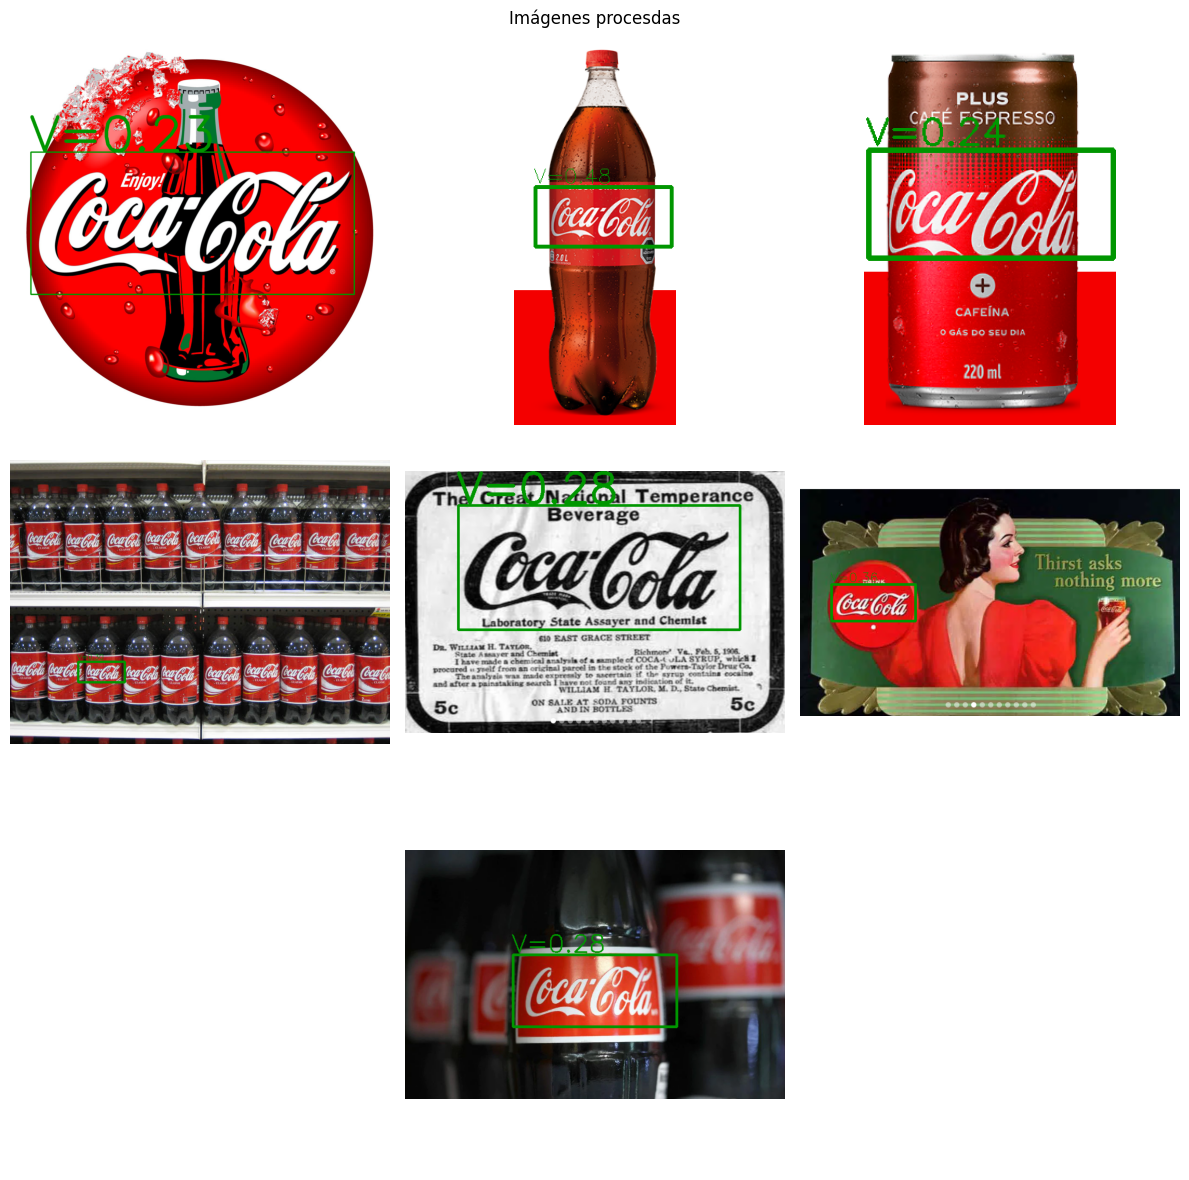

In [65]:
show_imgs([detect_one_object(img.copy(), template_rgb, (0.05, 3, 100), debug=False) for img in imgs_rgb], title='Imágenes procesdas')

*Podemos ver que efectivamente encuentra los logos, sin embargo, es dependiende de que "justo" la escala sea la adecuada. Es por esto que se pone un gran espacio de búsqueda.*

## Parte 2

> Plantear y validadr un algoritmo para múltiples detecciones en la imagen "coca_multi.png" con el mismo template del item 1

*Como investigación, primeramente vamos a graficar los valores de los máximos y sus escalas para cada imagen:*

🔮 <em><font color='violet'><strong>Función auxiliar:</strong> Se muestra los plots de una lista en una grilla.</font></em>

In [66]:
def show_plots(data, title=None, col_count=3, figsize=(12, 4)):
    items_count = len(data)

    # Calculo la cantidad de filas según las columnas deseadas
    rows = (items_count // col_count) + (1 if items_count % col_count != 0 else 0)

    fig, axes = plt.subplots(rows, col_count, figsize=(figsize[0], figsize[1] * rows))
    fig.suptitle(title)

    if rows * col_count == items_count:
        for i in range(rows * col_count):
            row = i // col_count
            col = i % col_count
            if i < items_count:
                x_values = [scale for _, scale in data[i]]
                y_values = [max_val for max_val, _ in data[i]]
                axes[row, col].plot(x_values, y_values)
    else:
        for i in range((rows - 1) * col_count):
            row = i // col_count
            col = i % col_count
            if i < items_count:
                x_values = [scale for _, scale in data[i]]
                y_values = [max_val for max_val, _ in data[i]]
                axes[row, col].plot(x_values, y_values)

        cols_used = items_count % col_count
        cols_empty = col_count - cols_used
        col_center = cols_empty // 2

        for col in range(col_count):
            if col < col_center or col >= col_center + cols_used:
                axes[rows - 1, col].axis('off')
            else:
                data_index = (rows - 1) * col_count + (col - col_center)
                x_values = [scale for _, scale in data[data_index]]
                y_values = [max_val for max_val, _ in data[data_index]]
                axes[rows - 1, col].plot(x_values, y_values)         

    plt.tight_layout()
    plt.show()

🔮 <em><font color='violet'><strong>Función auxiliar:</strong> Obtiene los resultados de cada pasada del template por una escala diferente.</font></em>

In [67]:
def detect_results(img_rgb: np.ndarray, template_rgb: np.ndarray, linspace: Tuple = (0.05, 2, 100), canny_thresshold: Tuple = (50, 200), method=cv.TM_CCORR_NORMED, threshold: float = 0.30, debug=True, show_best_result=True) -> np.ndarray:
    canny_low, canny_high = canny_thresshold
    template_edge = cv.Canny(cv.cvtColor(template_rgb, cv.COLOR_BGR2GRAY), canny_low, canny_high, L2gradient=True)
    img_edges_list = compute_all_img_sizes(img_rgb, canny_thresshold, linspace)
    
    h, w = template_edge.shape
    
    results = []
    for img_edges, scale in img_edges_list:
        img_h, img_w = img_edges.shape
        
        if img_h < h or img_w < w:
            break
        
        result = cv.matchTemplate(img_edges, template_edge, method)
        (_, max_val, _, _) = cv.minMaxLoc(result)
        
        results.append((max_val, scale))
        
    return results

*Mostramos los gráficos para todas las imágenes para ver los valores de la métrica:*

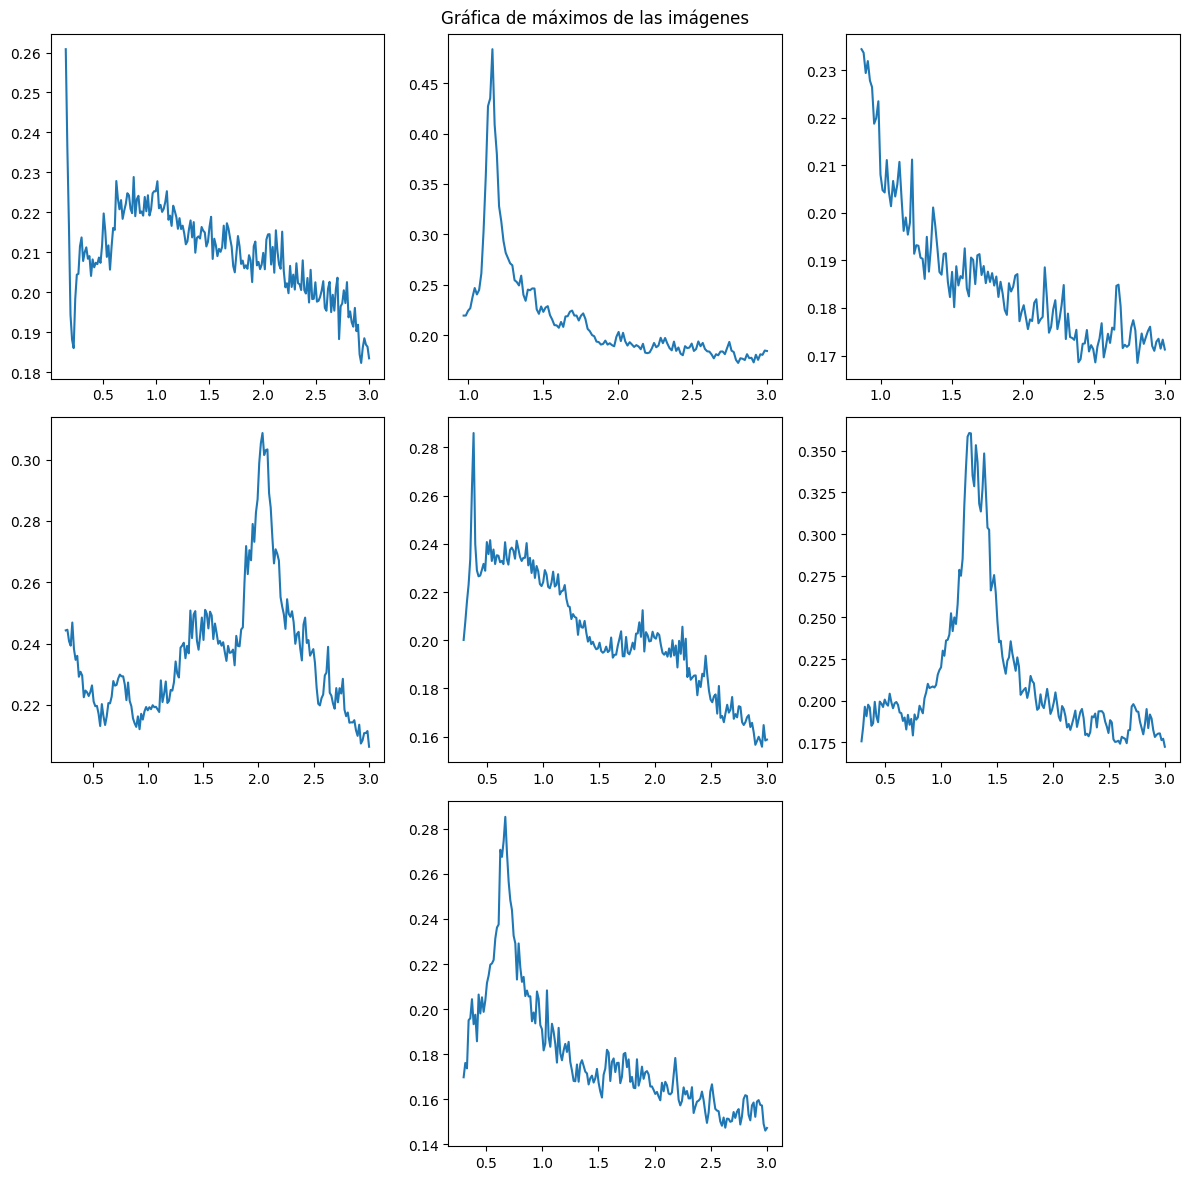

In [68]:
show_plots([detect_results(img.copy(), template_rgb, (0.05, 3, 200)) for img in imgs_rgb], title='Gráfica de máximos de las imágenes')

*En este punto, podemos identificar como mejor umbral el valor sobre **0.23.***

*El algoritmo hace lo mismo que el de detección de un objeto, solamente que en vez de quedarse con el máximo, se queda con los casos mayores a un umbral. Luego se aplica non maxial supression para eliminar los boxes excedentes (se utiliza la función de OpenCV para esto, y se adapta las estructuras para que sean acordes a la entrada de dicha función):*

In [70]:
def detect_multiple_objects(img_rgb: np.ndarray, template_rgb: np.ndarray, linspace: Tuple = (0.05, 2, 100), canny_thresshold: Tuple = (50, 200), method=cv.TM_CCORR_NORMED, threshold: float = 0.25, nms_threshold: float = 100, debug=True, show_best_result=True) -> np.ndarray:
    canny_low, canny_high = canny_thresshold
    template_edge = cv.Canny(cv.cvtColor(template_rgb, cv.COLOR_BGR2GRAY), canny_low, canny_high, L2gradient=True)
    img_edges_list = compute_all_img_sizes(img_rgb, canny_thresshold, linspace)
    
    h, w = template_edge.shape    
    if debug: print(f'Cantidad de imagenes a procesar: {len(img_edges_list)}')
    
    best_result = None    
    for img_edges, scale in img_edges_list:
        img_h, img_w = img_edges.shape
        
        if img_h < h or img_w < w:
            if debug: print(f'img_h, img_w : {(img_h, img_w)} | h, w: {(h, w)}')
            break
        
        result = cv.matchTemplate(img_edges, template_edge, method)
        # Obtengo los resultados mayor al umbral.
        result_threshold = np.nonzero(result >= threshold)
        
        # Obtengo todas las cajas dado este result_threshold
        bboxes = [[x, y, x+w, y+h, result[y][x]] for (y,x) in zip(*result_threshold)]
        
        # Sigo con la misma política de quedarme con el mejor resultado según la cantidad de matches
        best_result = (bboxes, scale) if (best_result is None) or (len(best_result[0]) < len(bboxes)) else best_result
        if debug: print(f'img_edges: {img_edges.shape} | img_edge.scale: {scale:.2f} | resultado_actual: {len(bboxes)} | mejor_resultado: {(len(best_result[0]), best_result[1])} | resutls.len: {len(result_threshold[0])}')
    
    # Aplico NMS
    try:
        best_bboxes, best_scale = best_result
        best_bboxes = np.array(best_bboxes)
        scores = best_bboxes[:, 4]
        boxes = best_bboxes[:, :4]
        best_boxes_index = cv.dnn.NMSBoxes(boxes, scores, score_threshold=threshold, nms_threshold=nms_threshold)
        best_boxes = best_bboxes[best_boxes_index]

        for box in best_boxes:
            x1, y1, x2, y2, confidence = box
            top_left = (int(x1/best_scale), int(y1/best_scale))
            bottom_right = (int(x2/best_scale), int(y2/best_scale))
            cv.rectangle(img_rgb, top_left, bottom_right, (0, 150, 0), 4)
            cv.putText(img_rgb, f'V={confidence:.2f}', (top_left[0] - 2, top_left[1] - 5), cv.FONT_HERSHEY_SIMPLEX, 1 / best_scale, (0, 150, 0),  int(2 / best_scale))    
        
        if debug or show_best_result: 
            print(f'Mejor resultado: {len(best_bboxes)} | Escala: {best_scale:.2f}')
    except:
        print('Explotó (best_bboxes está vacio). Probá agregar mas iteraciones o cambiar el threshold')
        
    return img_rgb

*Aplicamos el algoritmo y mostramos las imágenes:*

Mejor resultado: 15 | Escala: 0.16
Mejor resultado: 65 | Escala: 1.29
Mejor resultado: 4 | Escala: 0.88
Mejor resultado: 191 | Escala: 2.07
Mejor resultado: 20 | Escala: 0.38
Mejor resultado: 82 | Escala: 1.30
Mejor resultado: 20 | Escala: 0.65


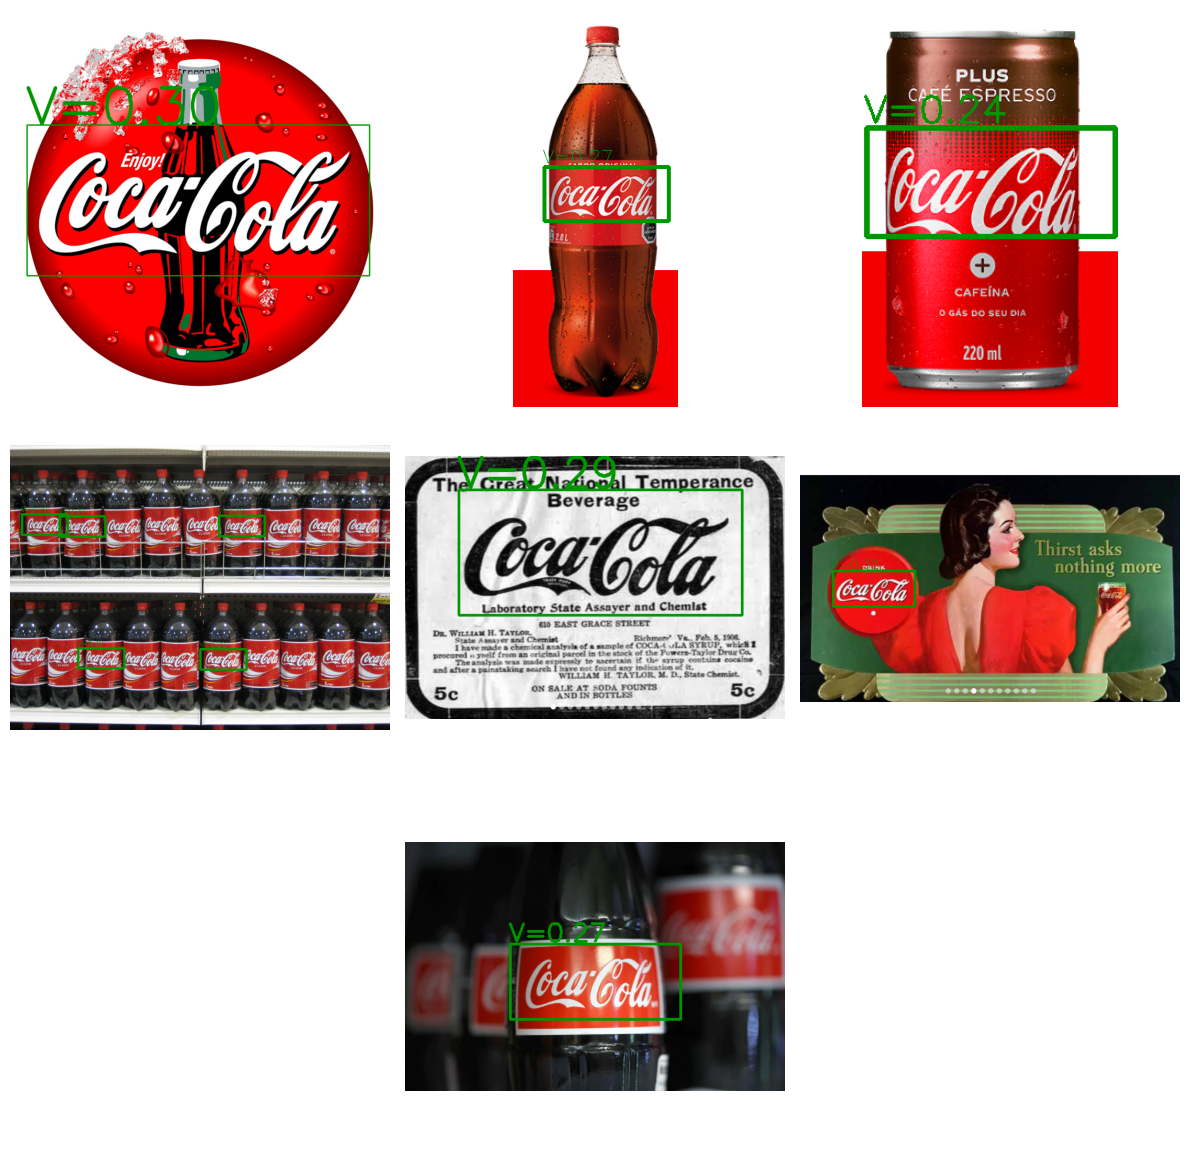

In [71]:
show_imgs([detect_multiple_objects(img.copy(), template_rgb, (0.15, 2.1, 200), threshold=0.23, nms_threshold=0.2, debug=False) for img in imgs_rgb])

*Vemos que detecta correctamente los objetos únicos y varios objetos también. Sin embargo, puede pasar que nuevamente el umbral no sea el correcto. También aumentando el umbral del algoritmo NMS podríamos detectar más objetos.*

## Parte 3

> Generalizar el algoritmo del item 2 para todas las imágenes

*Si bien el algoritmo del paso anteiror, también funciona para todas las imágenes, en este paso se generaliza (y se documenta como algoritmo final) para todas las imágenes independientemente del threshold. Lo que se hace es fijarse en un entorno del punto máximo. Luego el resto es igual.*

In [72]:
def super_detector(img_rgb: np.ndarray, template_rgb: np.ndarray, linspace: Tuple = (0.05, 2, 100), canny_thresshold: Tuple = (50, 200), method=cv.TM_CCORR_NORMED, nms_threshold: float = 100, debug=True, show_best_result=True) -> np.ndarray:
    """
    Detecta objetos en una imagen usando template matching y non-maximum suppression.

    Args:
        img_rgb (np.ndarray): Imagen de entrada en formato RGB.
        template_rgb (np.ndarray): Plantilla del objeto a detectar en formato RGB.
        linspace (Tuple): Parámetros para escalar la imagen (inicio, fin, pasos).
        canny_thresshold (Tuple): Umbrales bajo y alto para el detector de bordes Canny.
        method: Método de comparación para template matching.
        nms_threshold (float): Umbral para non-maximum suppression.
        debug (bool): Si es True, imprime información de depuración.
        show_best_result (bool): Si es True, muestra el mejor resultado.

    Returns:
        np.ndarray: Imagen original con los objetos detectados marcados.

    El algoritmo funciona de la siguiente manera:
    1. Prepara la plantilla y la imagen de entrada.
    2. Itera sobre diferentes escalas de la imagen.
    3. Aplica template matching en cada escala.
    4. Encuentra la mejor coincidencia entre todas las escalas.
    5. Aplica non-maximum suppression para eliminar detecciones redundantes.
    6. Dibuja los rectángulos de las detecciones en la imagen original.
    """
    canny_low, canny_high = canny_thresshold
    template_edge = cv.Canny(cv.cvtColor(
        template_rgb, cv.COLOR_BGR2GRAY), canny_low, canny_high, L2gradient=True)
    img_edges_list = compute_all_img_sizes(img_rgb, canny_thresshold, linspace)
    h, w = template_edge.shape
    if debug:
        print(f'Cantidad de imagenes a procesar: {len(img_edges_list)}')
    best_result = None
    for i, (img_edges, scale) in enumerate(img_edges_list):
        img_h, img_w = img_edges.shape
        if img_h < h or img_w < w:
            if debug:
                print(f'img_h, img_w : {(img_h, img_w)} | h, w: {(h, w)}')
            break
        result = cv.matchTemplate(img_edges, template_edge, method)
        (_, max_val, _, max_loc) = cv.minMaxLoc(result)
        threshold = max_val - 0.05
        result_threshold = np.nonzero(result >= threshold)
        bboxes = [[x, y, x+w, y+h, result[y][x]]
                  for (y, x) in zip(*result_threshold)]
        best_result = (max_val, max_loc, scale, bboxes, threshold, i) if (
            best_result == None) or (best_result[0] < max_val) else best_result
        if debug:
            print(f'iteracion: {i} | mejor_iteracion: {best_result[5]} | mejor_resultado: {(round(best_result[0], 4), best_result[1], round(best_result[2], 4), len(
                best_result[3]), round(best_result[4], 4))} | actual: {(round(max_val, 4), max_loc, round(scale, 4), len(bboxes), round(threshold, 4))}')

    # Aplica NMS y dibuja los resultados
    max_val, max_loc, best_scale, best_bboxes, threshold, _ = best_result
    best_bboxes = np.array(best_bboxes)
    scores = best_bboxes[:, 4]
    boxes = best_bboxes[:, :4]
    best_boxes_index = cv.dnn.NMSBoxes(
        boxes, scores, score_threshold=threshold, nms_threshold=nms_threshold)
    boxes_filtered = best_bboxes[best_boxes_index]
    for box in boxes_filtered:
        x1, y1, x2, y2, confidence = box
        top_left = (int(x1/best_scale), int(y1/best_scale))
        bottom_right = (int(x2/best_scale), int(y2/best_scale))
        cv.rectangle(img_rgb, top_left, bottom_right, (0, 150, 0), 4)
        cv.putText(img_rgb, f'V={confidence:.2f}', (top_left[0] - 2, top_left[1] - 5),
                   cv.FONT_HERSHEY_SIMPLEX, 1 / best_scale, (0, 150, 0),  int(2 / best_scale))
    if debug or show_best_result:
        print(f'Mejor resultado: {max_val:.2f} | Escala: {
              best_scale:.2f} | objects_detected: {len(boxes_filtered)}')
    return img_rgb

*Finalmente, aplicamos el super algoritmo:*

Mejor resultado: 0.30 | Escala: 0.16 | objects_detected: 1
Mejor resultado: 0.47 | Escala: 1.15 | objects_detected: 1
Mejor resultado: 0.24 | Escala: 0.88 | objects_detected: 1
Mejor resultado: 0.31 | Escala: 2.02 | objects_detected: 13
Mejor resultado: 0.29 | Escala: 0.38 | objects_detected: 1
Mejor resultado: 0.38 | Escala: 1.24 | objects_detected: 1
Mejor resultado: 0.29 | Escala: 0.67 | objects_detected: 1


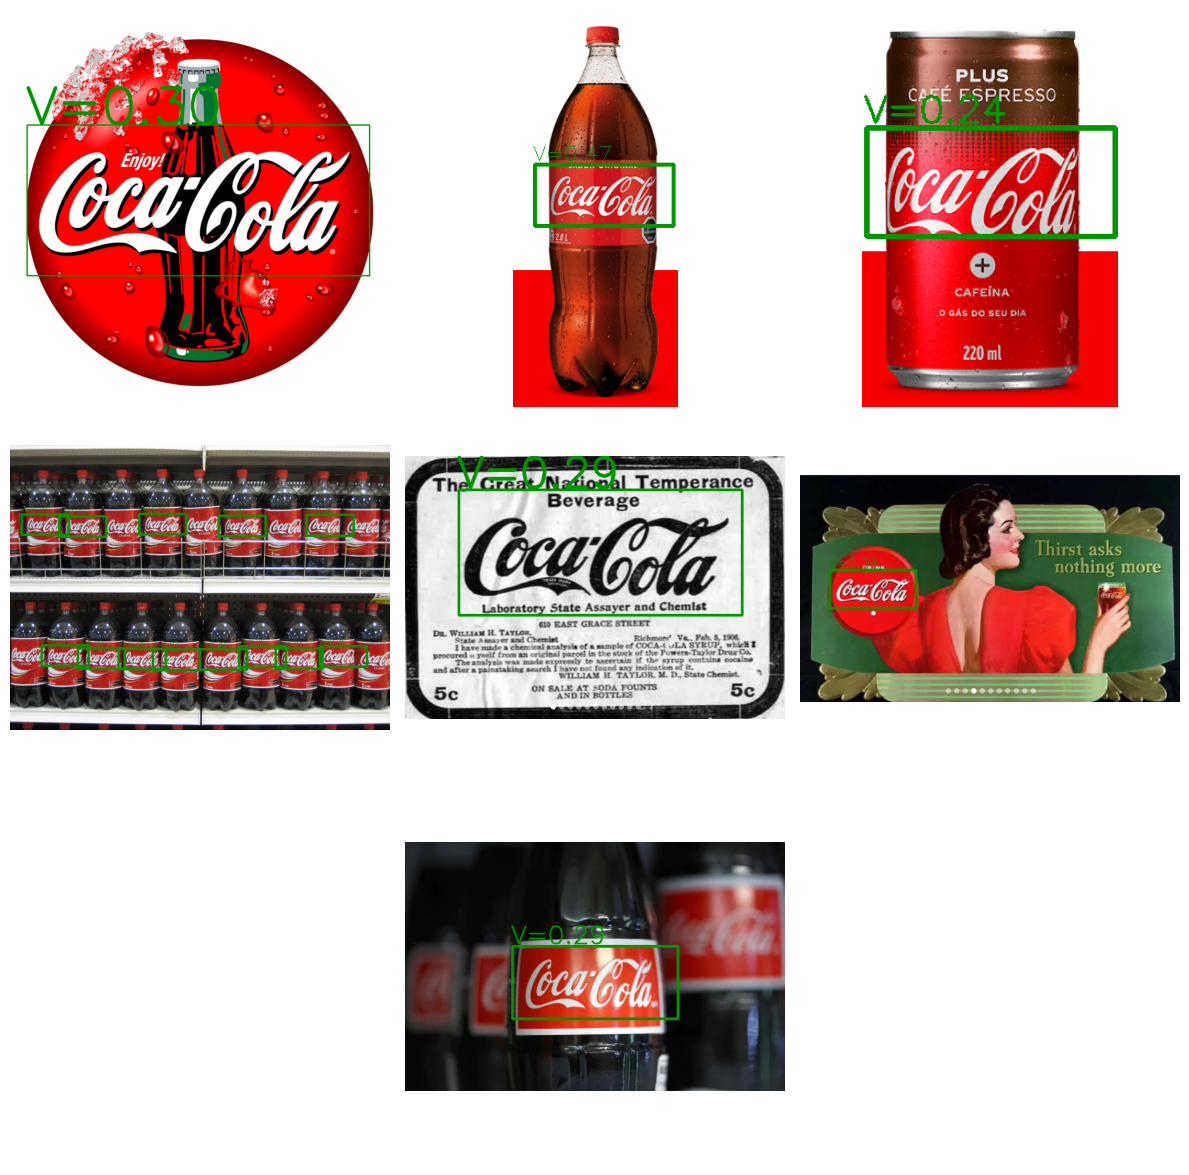

In [73]:
show_imgs([super_detector(img.copy(), template_rgb, (0.15, 2.1, 200), nms_threshold=0.7, debug=False) for img in imgs_rgb])

⭐**Conclusión**⭐

*Como conclusión final, podemos ver que el super algoritmo función muy bien en comparación con el anterior, y además no es necesario pre-calcular un umbral. Para el caso de **NMS=0.7**, devuelve 13 objetos, si le aumentamos un punto, ya empieza a dar falsos positivos en algunas otras imágenes, por lo que parecería que el valor ideal anda por ese número. También el espacio de búsqueda **linspace=(0.15, 2.1, 200)** parecería ser ideal también, ya que la escala mínima es de 0.16 y la máxima es de 2.05 (justamente la imágen con muchos objetos); sin embargo, este valor no es mucho problema, ya que se puede aumentar pero también aumenta la complejidad en tiempo y espacio acorde. Es más, para 300 ya se murió la máquina unas dos veces...*

<font color='orange'>⚠</font> *Problemas detectados:* <font color='orange'>⚠</font>
<em>
1. Inicialmente, se planteó variar el tamaño del template, para así tener una mejora en optimización, ya que el template podría estar pre-procesado en sus distintos tamaños. Esto no fue fructífero, dado que siempre se devolvía el template de menor tamaño o similar como mejor métrica. Tampoco ubicaba bien los logos.
2. Luego se probó tomar otro enfoque, hacer que las imágenes varien de tamaño. Este enfoque dió un mejor resultado, pero nuevamente tomaba la menor imágen. Esto es porque el template era más grande que la imagen.
3. Finalmente, se tomó la desición de computar las variaciones hasta que la imagen sea del tamaño del template, por lo que inicialmente se tuvo que reducir el tamaño del template para adpatarse a esta solución.
4. Si se aplicaba la solución inicial (la de variar el tamaño del template), y se comenzaba con el template de mayor tamaño, no se sabía cuando parar, por lo que no se siguió este camino.
5. El orden de aplicar Canny y resize importan. Se puede llegar a perder hasta un día por eso... Primero se hace resize y luego se aplica Canny.
</em>